<a href="https://colab.research.google.com/github/RH00000/UH_RTS_Research_ML/blob/main/simulation_gridsearch_same_confidence_with_3_ways_of_skip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Upload the profiling NPZ file from local machine (Colab)
from google.colab import files
uploaded = files.upload()

Saving abcd_profiling_validation_stats.npz to abcd_profiling_validation_stats.npz


In [2]:
# 1: Load profiling data
import numpy as np
import pandas as pd

data = np.load('abcd_profiling_validation_stats.npz')  # uses the uploaded file
confs = data['confs']    # shape (N,4)
times = data['times']    # shape (N,4)
oks   = data['oks']      # shape (N,4), bool
N, M = confs.shape       # N samples, M=4 models (A,B,C,D)

In [3]:
def simulate_cascade(confs, times, oks,
                     thr_a, thr_b, thr_c,
                     skip_b_thresh, skip_c_thresh):
    total_time     = 0.0
    correct        = 0
    skip_c_count   = 0
    skip_bc_count  = 0
    skip_b_to_c_count    = 0

    for j in range(N):
        # run A
        conf_a = confs[j,0]; t_a = times[j,0]; ok_a = oks[j,0]
        if conf_a >= thr_a:
            total_time += t_a
            correct    += ok_a
            continue

        # skip B?
        skip_b = (conf_a < skip_b_thresh)
        if not skip_b:
            # run B
            total_time += times[j,1]
            conf_b     = confs[j,1]
            ok_b       = oks[j,1]
            if conf_b >= thr_b:
                correct += ok_b
                continue
        else:
            conf_b = None

        # Decide skip C using conf_a if B skipped, else conf_b
        if skip_b:
            metric_for_c = conf_a
        else:
            metric_for_c = conf_b
        skip_c = (metric_for_c < skip_c_thresh)

        # increment appropriate counters
        if skip_b and not skip_c:
            skip_b_to_c_count += 1
        if skip_c and not skip_b:
            skip_c_count += 1
        if skip_b and skip_c:
            skip_bc_count += 1

        if not skip_c:
            # run C
            total_time += times[j,2]
            conf_c     = confs[j,2]
            ok_c       = oks[j,2]
            if conf_c >= thr_c:
                correct += ok_c
                continue

        # fallback D
        total_time += times[j,3]
        correct    += oks[j,3]

    Nf = float(N)
    return (
      correct / Nf,
      total_time / Nf,
      skip_c_count  / Nf,
      skip_bc_count / Nf,
      skip_b_to_c_count   / Nf   # NEW return value
    )

In [11]:
# 3: Define grid of thresholds to search
# np.linspace(start, end, num) generates 'num' evenly spaced values from start to end (inclusive).
# For example, np.linspace(0.5, 0.9, 5) produces [0.5, 0.6, 0.7, 0.8, 0.9].
# Step 3: Define grid of thresholds to search
# Use np.arange(start, stop, step) to generate values with a specific increment.
shared_thrs = np.arange(0.70, 0.951, 0.05) # [0.70,0.75,0.80,0.85,0.90,0.95]
# Skip thresholds
skip_bs = np.arange(0.10, 0.51, 0.05) # [0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50]
skip_cs = np.arange(0.10, 0.51, 0.05)

In [12]:
# 4: Grid search over all combinations
records = []
total_iters = len(shared_thrs) * len(skip_bs) * len(skip_cs)
iter_count = 0

for shared_thr in shared_thrs:
    # set all three IDK thresholds to the same value
    thr_a = thr_b = thr_c = shared_thr

    for skip_b in skip_bs:
        for skip_c in skip_cs:
            # simulate with these five parameters
            acc, t, r_c, r_bc, r_b_to_c = simulate_cascade(
                confs, times, oks,
                thr_a, thr_b, thr_c,
                skip_b, skip_c
            )
            records.append({
                'shared_thr':    shared_thr,
                'skip_b_thresh': skip_b,
                'skip_c_thresh': skip_c,
                'accuracy':      acc,
                'avg_time':      t,
                'skip_C→D_rate':      r_c,
                'skip_B,C→D_rate':    r_bc,
                'skip_B→C_rate':      r_b_to_c,
            })

            # Light logging every 100 simulations
            iter_count += 1
            if iter_count % 100 == 0:
                print(f"Completed {iter_count}/{total_iters} grid points")

Completed 100/486 grid points
Completed 200/486 grid points
Completed 300/486 grid points
Completed 400/486 grid points


In [ ]:
# 5: Analyze results
# Convert to DataFrame for easy sorting/filtering
df = pd.DataFrame(records)
# Filter by accuracy, sort by average time
target_accuracy = 0.70
best = df[df['accuracy'] >= target_accuracy].sort_values('avg_time').head(15)
print(best)

In [38]:
# Filter by confidence threshold, sort by average time
target_conf_threshold = 0.7
best_times = df[df['shared_thr'] >= target_conf_threshold].sort_values('avg_time').head(10)
print(best_times)

    shared_thr  skip_b_thresh  skip_c_thresh  accuracy  avg_time  \
71         0.7           0.45           0.50    0.7936  0.010395   
69         0.7           0.45           0.40    0.7924  0.010399   
70         0.7           0.45           0.45    0.7928  0.010404   
62         0.7           0.40           0.50    0.7940  0.010421   
68         0.7           0.45           0.35    0.7920  0.010425   
79         0.7           0.50           0.45    0.7932  0.010453   
78         0.7           0.50           0.40    0.7928  0.010454   
67         0.7           0.45           0.30    0.7920  0.010455   
61         0.7           0.40           0.45    0.7932  0.010458   
60         0.7           0.40           0.40    0.7928  0.010461   

    skip_C→D_rate  skip_B,C→D_rate  skip_B→C_rate  
71         0.0408           0.2076         0.0000  
69         0.0228           0.1732         0.0344  
70         0.0332           0.2076         0.0000  
62         0.0544           0.1732         

In [39]:
target_conf_threshold = 0.85
best_times = df[df['shared_thr'] >= target_conf_threshold].sort_values('avg_time').head(10)
print(best_times)

     shared_thr  skip_b_thresh  skip_c_thresh  accuracy  avg_time  \
323        0.85           0.50           0.50    0.8016  0.013503   
314        0.85           0.45           0.50    0.8020  0.013650   
322        0.85           0.50           0.45    0.8016  0.013693   
313        0.85           0.45           0.45    0.8020  0.013712   
305        0.85           0.40           0.50    0.8024  0.013802   
321        0.85           0.50           0.40    0.8016  0.013833   
312        0.85           0.45           0.40    0.8020  0.013869   
304        0.85           0.40           0.45    0.8024  0.013898   
296        0.85           0.35           0.50    0.8024  0.013946   
303        0.85           0.40           0.40    0.8024  0.013970   

     skip_C→D_rate  skip_B,C→D_rate  skip_B→C_rate  
323         0.0460           0.2460         0.0000  
314         0.0592           0.2076         0.0000  
322         0.0340           0.2076         0.0384  
313         0.0440          

In [40]:
target_conf_threshold = 0.95
best_times = df[df['shared_thr'] >= target_conf_threshold].sort_values('avg_time').head(10)
print(best_times)

     shared_thr  skip_b_thresh  skip_c_thresh  accuracy  avg_time  \
485        0.95           0.50           0.50       0.8  0.016914   
484        0.95           0.50           0.45       0.8  0.017196   
476        0.95           0.45           0.50       0.8  0.017219   
475        0.95           0.45           0.45       0.8  0.017301   
483        0.95           0.50           0.40       0.8  0.017479   
467        0.95           0.40           0.50       0.8  0.017531   
474        0.95           0.45           0.40       0.8  0.017602   
466        0.95           0.40           0.45       0.8  0.017647   
482        0.95           0.50           0.35       0.8  0.017722   
465        0.95           0.40           0.40       0.8  0.017750   

     skip_C→D_rate  skip_B,C→D_rate  skip_B→C_rate  
485         0.0512           0.2460         0.0000  
484         0.0384           0.2076         0.0384  
476         0.0644           0.2076         0.0000  
475         0.0484          

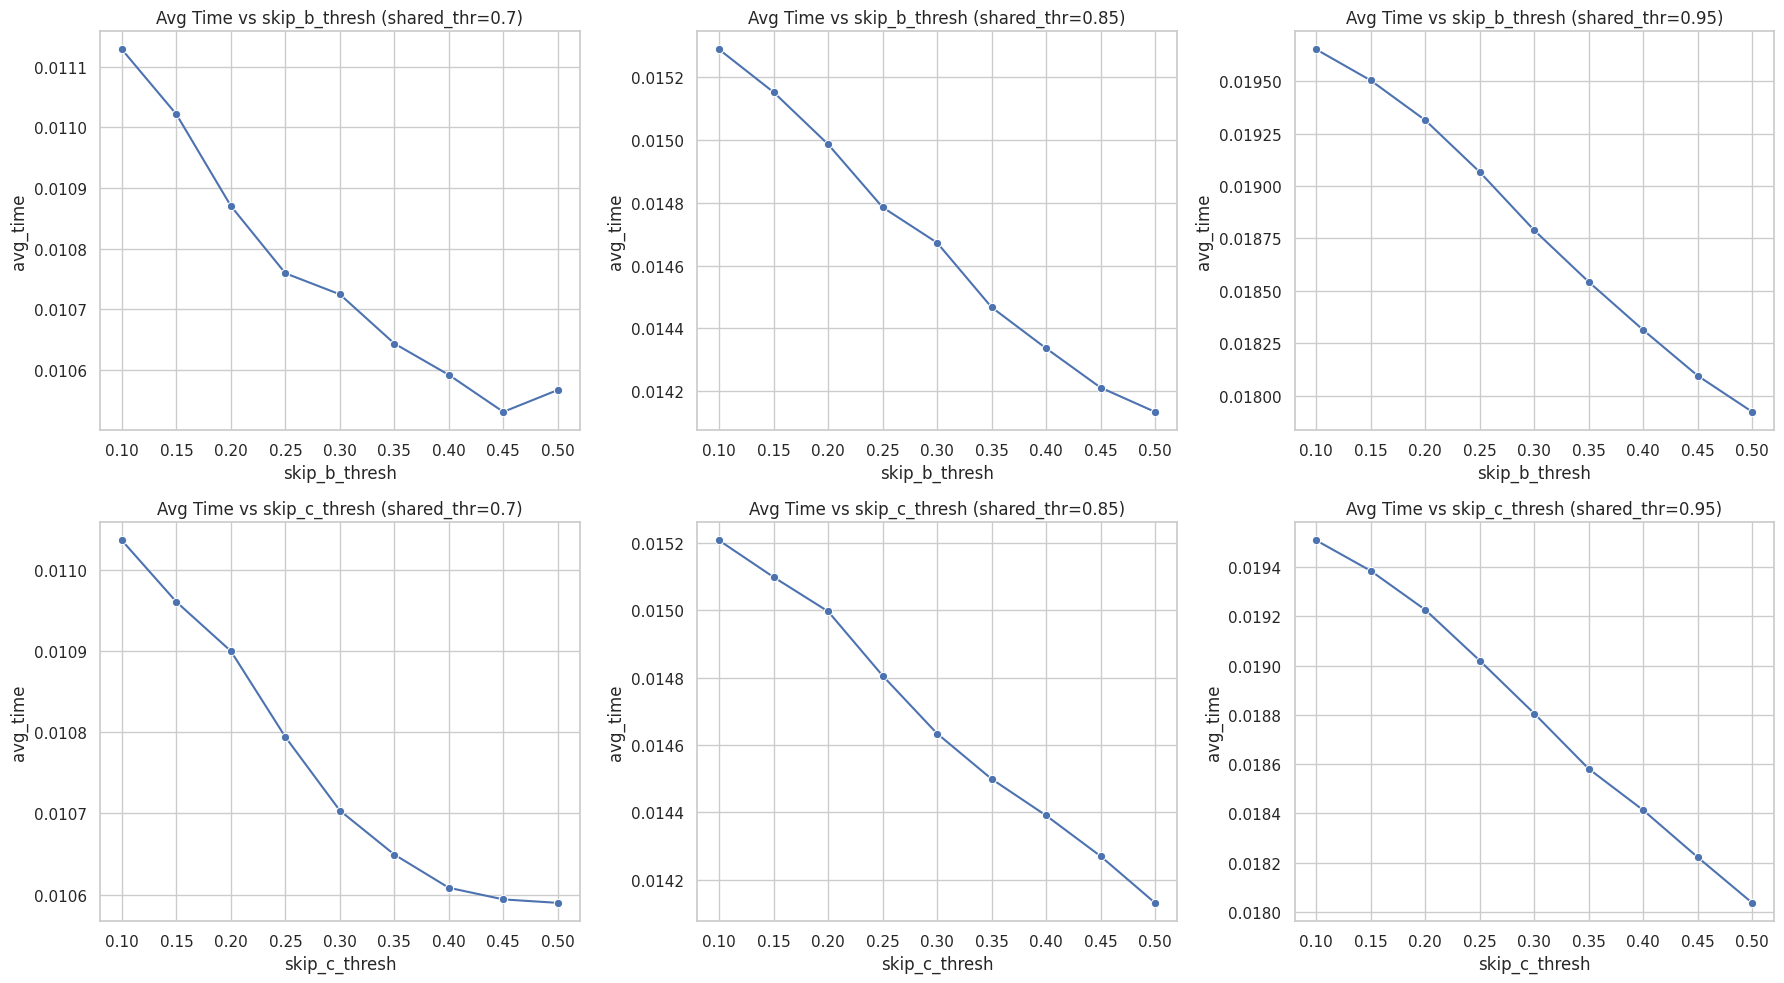

In [36]:
# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure correct column types
df['shared_thr'] = df['shared_thr'].astype(float)

# Select thresholds to plot
conf_levels = [0.70, 0.85, 0.95]

# seaborn theme
sns.set(style="whitegrid")
plt.figure(figsize=(18, 10))

# Plot 1,2,3: skip_b_thresh vs avg_time
for idx, conf in enumerate(conf_levels):
    plt.subplot(2, 3, idx + 1)
    df_conf = df[np.isclose(df['shared_thr'], conf)]
    df_plot = df_conf.groupby('skip_b_thresh')['avg_time'].mean().reset_index()
    sns.lineplot(x='skip_b_thresh', y='avg_time', data=df_plot, marker='o')
    plt.title(f'Avg Time vs skip_b_thresh (shared_thr={conf})')
    plt.xlabel('skip_b_thresh')
    plt.ylabel('avg_time')

# Plot 4,5,6: skip_c_thresh vs avg_time
for idx, conf in enumerate(conf_levels):
    plt.subplot(2, 3, idx + 4)
    df_conf = df[np.isclose(df['shared_thr'], conf)]
    df_plot = df_conf.groupby('skip_c_thresh')['avg_time'].mean().reset_index()
    sns.lineplot(x='skip_c_thresh', y='avg_time', data=df_plot, marker='o')
    plt.title(f'Avg Time vs skip_c_thresh (shared_thr={conf})')
    plt.xlabel('skip_c_thresh')
    plt.ylabel('avg_time')

plt.tight_layout()
plt.show()

In [ ]:
#maybe plotting a graph with both skip_b and skip_c thresholds?

In [8]:
# Save full results to CSV
df.to_csv('gridsearch_same_confidence_with_3_ways_to_skip.csv', index=False)
print("Saved full grid results to 'gridsearch_same_confidence_with_3_ways_to_skip.csv'")

Saved full grid results to 'gridsearch_same_confidence_with_3_ways_to_skip.csv'


In [10]:
# # Download CSV to local machine (in Colab)
# from google.colab import files
# files.download('gridsearch_same_confidence_with_3_ways_to_skip.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>